## Notebook Description
This notebook contains the code for comparing the performance of out-of-the-box models as fixed feature extractors <br>
**Date of Last Update**: November 25th 2020

---

**INPUTS**: Data/train, Data/val, Data/validation <br>
directory containing image files sorted by class and train test val

**OUTPUTS**: Model Choice<br>

---

### Previous Steps
- performing train/test/val split

### Next Steps
- fine tuning of model

---

## Import Packages

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim 
import torchvision
from torchvision import models, transforms, datasets

import numpy as np
import matplotlib.pyplot as plt
import time 
import os
import copy
import pandas as pd
import plotly.express as px

## Load Data
- perform data augmentation on train set
- resize and crop

In [2]:
# prep data transforms
data_transforms = {
    # data augmentation as well as data normalization
    "train" : transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # only resize, crop and normalize
    "val" : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [3]:
path = 'Data'

image_datasets = {x: datasets.ImageFolder(os.path.join(path, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=2)
                   for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

## Define Function to Train Model
- takes in the model, criterion, optimizer and number of epochs
- returns the max accuracy, max memory allocated and elapsed time

In [5]:
def train_model(model, criterion, optimizer, num_epochs):
    """Trains the Model
    INPUTS - model, criterion, optimizer, num_epochs:
    RETURNS - time_elapsed = time elapsed while training model
            - best_acc = maximum accuracy on validation set obtained while training"""
    
    start = time.time()
    
    best_acc = 0.0
    max_memory = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch ', epoch+1, ' of ', num_epochs)
        
        for phase in ['train', 'val'] : 
            if phase == 'train':
                model.train()
            else: 
                model.eval()
            
            running_loss = 0.0
            no_correct = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs,1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train' : 
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                no_correct += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = no_correct.double() / dataset_sizes[phase]

            
            print(phase, " Loss: ", epoch_loss, " Accuracy: ", epoch_acc)
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
            
    time_elapsed = time.time() - start
    
    return time_elapsed, best_acc

## Load Selection of PreTrained Models
- available through torch.models

In [6]:
model_res18 = models.resnet18(pretrained = True)
model_res34 = models.resnet34(pretrained = True)
model_alex = models.alexnet(pretrained = True)
model_vgg11 = models.vgg11(pretrained = True)
model_vgg13 = models.vgg13(pretrained = True)
model_vgg16 =models.vgg16(pretrained = True)
model_vgg19 =models.vgg19(pretrained = True)
model_squeeze = models.squeezenet1_0(pretrained = True)

In [7]:
list_of_models = [model_res18, model_res34, model_alex, model_vgg11, model_vgg13, model_vgg16, model_vgg19, model_squeeze]
model_name = {1 : "ResNet18", 2: "ResNet34", 3 : "AlexNet",
             4 : "VGG11", 5 : "VGG13", 6 : "VGG16", 7 : "VGG19",
             8 : "SqueezeNet1.0"}
model_layers = {"ResNet18" : 18, "ResNet34" : 34, "AlexNet" : 8,
            "VGG11" : 11,  "VGG13" : 13, "VGG16" : 16, "VGG19" : 19,
            "SqueezeNet1.0" : 13}

## Define Function to Train all Models
- function will train a list of models and store results in a dictionary 

In [8]:
def get_model_results (list_of_models, model_name):
    """Provides training results for a group of models
    INPUTS - list_of_models, model_name (dict)
    RETURNS - model_train_time : dict of elapsed time by model
            - model_acc : dict of best accuracy by model
            - model_mem : dict of max allocated memory by model"""
    
    # initalize variables
    i = 1
    model_train_time = {}
    model_acc = {}
    for model in list_of_models:
        #print which model is being trained
        print(model_name[i])
        print("-"*15)
        test = str(model).split('(')[0]
        
        #freeze convulational layers
        for params in model.parameters():
            params.requires_grad = False   
        
        #determine what classifier style we are dealing with
        if test == "ResNet" :
            model.fc = nn.Linear(512, 4)
            model = model.to(device)
            optimizer = optim.SGD(model.fc.parameters(), lr = 0.001, momentum = 0.9)
        elif test == "AlexNet" :
            model.classifier[6] = nn.Linear(4096,4)
            model = model.to(device)
            optimizer = optim.SGD(model.classifier.parameters(), lr = 0.001, momentum = 0.9)
        elif test == "VGG" :
            model.classifier[6] = nn.Linear(4096,4)
            model = model.to(device)
            optimizer = optim.SGD(model.classifier.parameters(), lr = 0.001, momentum = 0.9)
        elif test == "SqueezeNet" :
            model.classifier[1] = nn.Conv2d(512, 4, kernel_size=(1,1), stride=(1,1))
            model = model.to(device)
            optimizer = optim.SGD(model.classifier.parameters(), lr = 0.001, momentum = 0.9)
        
        criterion = nn.CrossEntropyLoss()
        
        # train model and add results to dictionary 
        timeelapsed, bestacc = train_model(model, criterion, optimizer, num_epochs = 25)
        model_train_time[model_name[i]] = timeelapsed
        model_acc[model_name[i]] = bestacc 
        i += 1
        
    return model_train_time, model_acc
        

In [9]:
model_train_time, model_acc = get_model_results(list_of_models, model_name)

ResNet18
---------------
Epoch  1  of  25
train  Loss:  1.168130105318025  Accuracy:  tensor(0.3372, dtype=torch.float64)
val  Loss:  0.786649209122325  Accuracy:  tensor(0.6977, dtype=torch.float64)
Epoch  2  of  25
train  Loss:  0.7060371789821359  Accuracy:  tensor(0.7558, dtype=torch.float64)
val  Loss:  0.6676385402679443  Accuracy:  tensor(0.6744, dtype=torch.float64)
Epoch  3  of  25
train  Loss:  0.6266213932702708  Accuracy:  tensor(0.7733, dtype=torch.float64)
val  Loss:  0.3441681626231171  Accuracy:  tensor(0.9302, dtype=torch.float64)
Epoch  4  of  25
train  Loss:  0.5145640442537707  Accuracy:  tensor(0.8198, dtype=torch.float64)
val  Loss:  0.4532360642455345  Accuracy:  tensor(0.7442, dtype=torch.float64)
Epoch  5  of  25
train  Loss:  0.5096094843953155  Accuracy:  tensor(0.7907, dtype=torch.float64)
val  Loss:  0.31321432112261305  Accuracy:  tensor(0.9070, dtype=torch.float64)
Epoch  6  of  25
train  Loss:  0.5258133168830428  Accuracy:  tensor(0.8081, dtype=torch.fl

In [10]:
for value in model_name.values():
    print(value)
    print('-'*15)
    print('Elapsed Time: ', model_train_time[value])
    print('Max Accuracy: ', model_acc[value])
    print('-'*15)

ResNet18
---------------
Elapsed Time:  1049.8626110553741
Max Accuracy:  tensor(0.9535, dtype=torch.float64)
---------------
ResNet34
---------------
Elapsed Time:  1222.5414361953735
Max Accuracy:  tensor(0.9535, dtype=torch.float64)
---------------
AlexNet
---------------
Elapsed Time:  694.2817440032959
Max Accuracy:  tensor(0.9535, dtype=torch.float64)
---------------
VGG11
---------------
Elapsed Time:  1926.1785368919373
Max Accuracy:  tensor(0.9302, dtype=torch.float64)
---------------
VGG13
---------------
Elapsed Time:  2836.8204250335693
Max Accuracy:  tensor(0.9302, dtype=torch.float64)
---------------
VGG16
---------------
Elapsed Time:  3454.8307690620422
Max Accuracy:  tensor(0.9302, dtype=torch.float64)
---------------
VGG19
---------------
Elapsed Time:  4947.522569894791
Max Accuracy:  tensor(0.9302, dtype=torch.float64)
---------------
SqueezeNet1.0
---------------
Elapsed Time:  1094.5165967941284
Max Accuracy:  tensor(0.9767, dtype=torch.float64)
---------------


## Define Function to Compare Results
- create plots comparing obtained information about the models

In [14]:
def plot_graphs(model_train_time, model_acc, model_layers):
    """Provide plots to compare results
    INPUTS - model_train_time, model_acc, model_layers
    RETURNS - None"""
    df = pd.DataFrame.from_dict(model_train_time, orient = 'index')
    df1 = pd.DataFrame.from_dict(model_acc, orient = 'index')
    df2 = pd.DataFrame.from_dict(model_layers, orient = 'index')
    df = df.merge(df1, left_index = True, right_index = True)
    df = df.merge(df2, left_index = True, right_index = True)
    df.rename(columns = {"0_x" : "train_time", 
                         "0_y" : "max_accuracy", 
                         0 : "model_layers"}, inplace = True)
    df = df.reset_index()
    
    fig = px.bar(df, x = 'index', y = 'train_time', title = "Comparison of Out-of-Box Train Time")
    fig.update_traces(marker_color = 'teal')
    fig.show()
    
    fig = px.bar(df, x = 'index', y = 'max_accuracy', title = "Comparison of Out-of-Box Accuracy")
    fig.update_traces(marker_color = 'teal')
    fig.show()
    
    fig = px.bar(df, x = 'index', y = 'model_layers', title = "Comparison of Out-of-Box Memory Requirements")
    fig.update_traces(marker_color = 'teal')
    fig.show()
    
    fig = px.scatter(df, x = 'train_time', y = 'max_accuracy', size = 'model_layers', color = 'index', 
                     title = "Comparison of Out-of-Box Models", color_discrete_sequence = px.colors.qualitative.Bold)
    fig.show()
    
    return
    

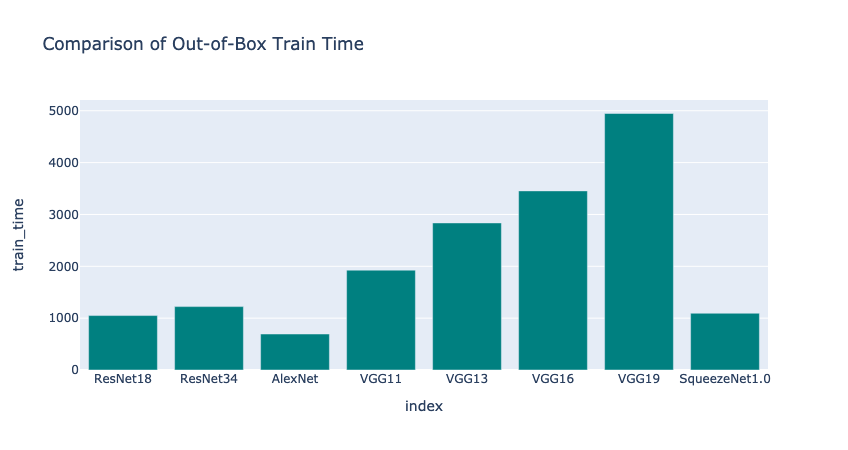

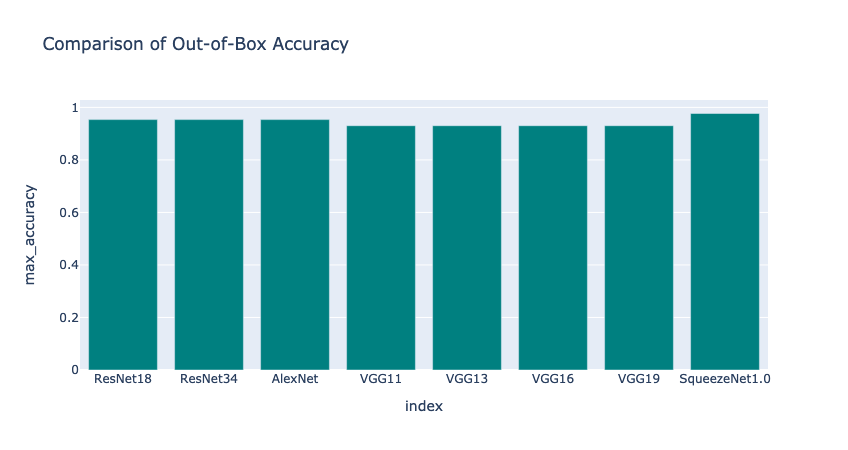

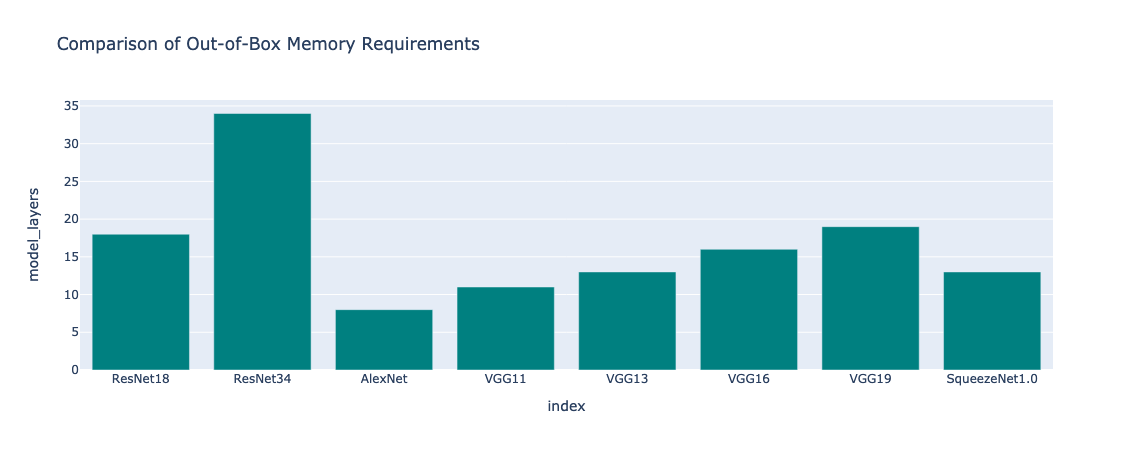

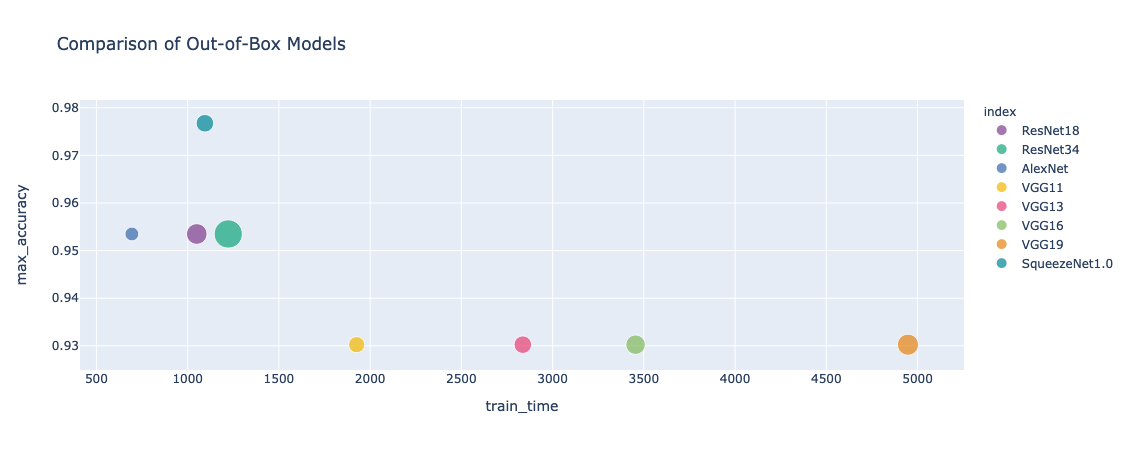

In [15]:
plot_graphs(model_train_time, model_acc, model_layers)

## Confusion Matrix Comparision of Selected Models
- create a confusion matrix for models shown to have high potential above
- compare to select final model

In [32]:
@torch.no_grad()
def get_all_predictions(model, loader):
    """Function to obtain a tensor of all predictions made by the model
    INPUTS - model, loader (batches of 1)
    OUTPUTS - predictions, tensor of predictions, labels, tensor of targets"""
    predictions = torch.tensor([])
    targets = torch.tensor([])
    for batch in loader:
        images, labels = batch
        
        pred = model(images)
        predictions = torch.cat((predictions, pred), dim=0)
    return predictions, labels

In [33]:
def get_num_correct(predictions, target):
    """determines the number of correct predictions made by the model
    INPUTS predictions, target
    RETURNS number correct
    """
    return predictions.argmax(dim=1).eq(target).sum().item()

In [71]:
def get_confusion_matrix_vals(model):
    """returns values for confusion matrix
    INPUTS model
    RETURNS cm, list of confusion matrix values"""
    with torch.no_grad():
        prediction_loader = torch.utils.data.DataLoader(image_datasets['val'], batch_size=10000)
        predictions, target = get_all_predictions(model, prediction_loader)
    preds = predictions.argmax(dim=1)
    stacked = torch.stack((target, preds),dim=1)
    cfm = torch.zeros(4,4, dtype=torch.int64)
    for s in stacked:
        tl, pl = s.tolist()
        cfm[tl, pl] = cfm[tl, pl] + 1
    cm = [[cfm[1][1], cfm[1][2], cfm[1][3]],[cfm[2][1], cfm[2][2], cfm[2][3]],[cfm[3][1], cfm[3][2], cfm[3][3]]]
    
    return cm

In [72]:
get_confusion_matrix_vals(model_alex)

[[tensor(13), tensor(1), tensor(1)],
 [tensor(1), tensor(12), tensor(0)],
 [tensor(2), tensor(1), tensor(12)]]

In [73]:
get_confusion_matrix_vals(model_res18)

[[tensor(14), tensor(0), tensor(1)],
 [tensor(0), tensor(12), tensor(1)],
 [tensor(1), tensor(0), tensor(14)]]

In [75]:
get_confusion_matrix_vals(model_squeeze)

[[tensor(12), tensor(2), tensor(1)],
 [tensor(1), tensor(11), tensor(1)],
 [tensor(1), tensor(0), tensor(14)]]